In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import norm, expon, sem

In [3]:
# Setup
np.random.seed(4198)

# Parameters
S_0, r, sig, T = 50, 0.05, 0.2, 1

K = [50, 60, 80, 100, 120]

n = 10_000
it_num = 10

In [7]:
# Define the payoff function
def european_call_payoff(x, S_0, r, sig, T, K):
    S_T = S_0 * np.exp((r - 0.5 * sig**2) * T + sig * np.sqrt(T) * x)
    
    payoff = np.maximum(S_T - K, 0)
    discounted_payoff = np.exp(-r * T) * payoff
    
    return discounted_payoff

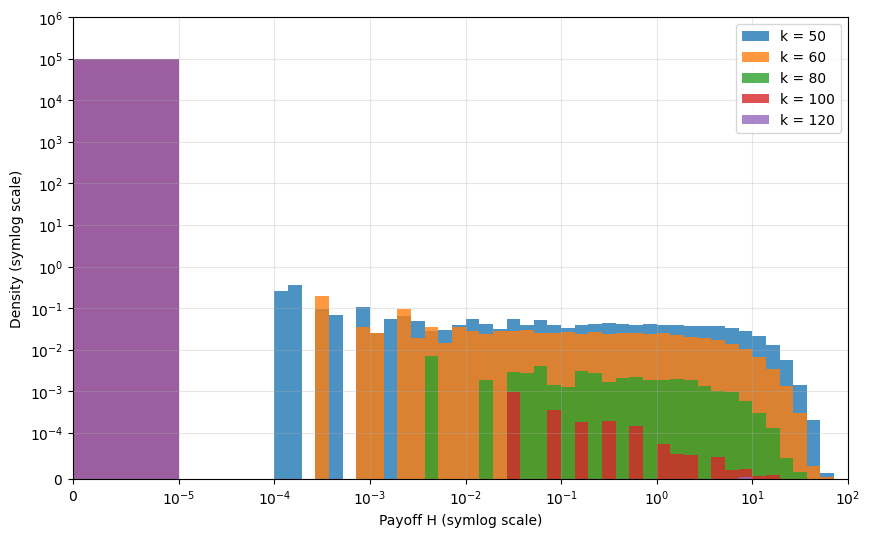

In [9]:
# Probability distribution of payoff h(x) when x ~ N(0, 1)
N = 100_000

# Define bins: linear near zero, log for larger values
linear_bins = np.linspace(0, 1e-5, 2)   # linear bins from 0 to small threshold
log_bins = np.logspace(-5, 2, 50)      # logarithmic bins for larger values
bin_edges = np.concatenate([linear_bins, log_bins[1:]])  # avoid duplicate at 1e-6

plt.figure(figsize=(10, 6))
for k in K:
    X = np.random.normal(size=N)
    H = european_call_payoff(X, S_0, r, sig, T, k)

    # plot the histogram of H for different k on the same figure 
    plt.hist(
        H, bins=bin_edges, density=True, alpha=0.8,
        label=f'k = {k}', histtype='stepfilled'
    )

# Use symlog scale for both axes
plt.xscale('symlog', linthresh=1e-5)
plt.yscale('symlog', linthresh=1e-4)

# Set limits to include 0 to 100 on x-axis
plt.xlim(0, 1e2)
plt.ylim(0, 1e6)  # keep y-limit as before

plt.xlabel('Payoff H (symlog scale)')
plt.ylabel('Density (symlog scale)')

plt.legend()
plt.grid(True, which='both', alpha=0.3)

plt.show()


In [10]:
def exponential_tilt(x, theta):
    """Compute the likelihood ratio for importance sampling."""
    return np.exp(-theta * x + 0.5 * theta**2)

opt_theta = [1.2330, 1.7632, 2.8631, 3.8209, 4.6657]

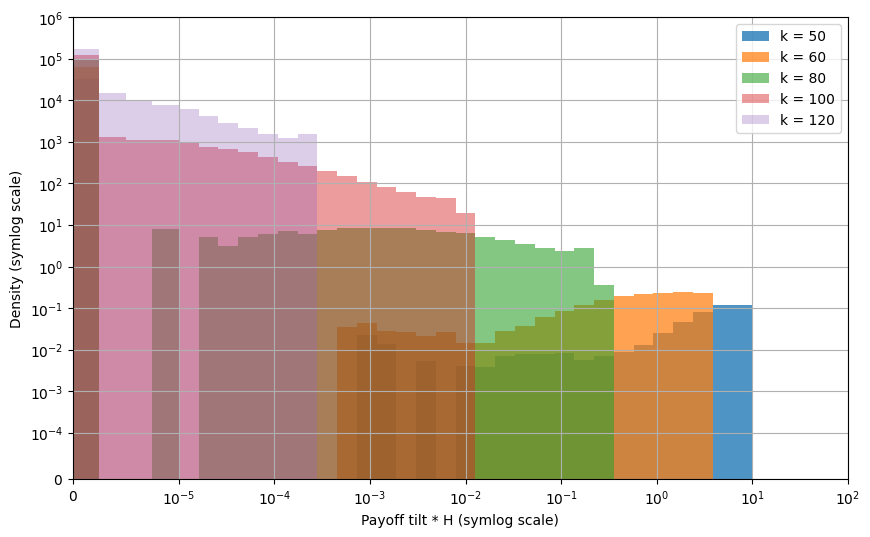

In [11]:
# Probability distribution of payoff tilt(x, theta) * h(x) when x ~ N(theta, 1)
N = 100_000

linear_bins = np.linspace(0, 1e-5, 5) 
log_bins = np.logspace(-5, 1, 30)  
bin_edges = np.concatenate([linear_bins, log_bins[1:]]) 

plt.figure(figsize=(10, 6))
for k in K:
    theta_k = opt_theta[K.index(k)]
    X = np.random.normal(loc=theta_k, scale=1.0, size=N)
    H = european_call_payoff(X, S_0, r, sig, T, k)
    H = exponential_tilt(X, theta_k) * H

    # plot the histogram of H for different k on the same figure 
    plt.hist(
        H, bins=bin_edges, density=True, alpha=0.8 * (1.4 - k / 120),
        label=f'k = {k}', histtype='stepfilled'
    )

plt.xscale('symlog', linthresh=1e-5)
plt.xlim(0, 1e2)

plt.yscale('symlog', linthresh=1e-4)
plt.ylim(0, 1e6)

plt.xlabel('Payoff tilt * H (symlog scale)')
plt.ylabel('Density (symlog scale)')

plt.legend()
plt.grid()

plt.show()

    

In [ ]:
from matplotlib.animation import FuncAnimation, PillowWriter
from IPython.display import HTML

# Parameters=
n = 100_000
k = 120

optimal_theta = 4.667
thetas = np.linspace(0.0, optimal_theta, 31)

ests = []
res = []

hist_data = []
linear_bins = np.linspace(0, 1e-6, 5)  # 0 to small value
log_bins = np.logspace(-6, 2, 40)     # remaining bins
bin_edges = np.concatenate([linear_bins, log_bins[1:]])  # avoid duplicate edge

# Precompute histograms
for theta in thetas:
    # Compute H
    X = np.random.normal(loc=theta, scale=1.0, size=n)
    H = european_call_payoff(X, S_0, r, sig, T, k)
    H = exponential_tilt(X, theta) * H

    est = np.mean(H)
    se = sem(H)
    re = se / np.abs(est)

    ests.append(est)
    res.append(re)

    # Compute histogram
    hist_data.append(H)

# Set up figure
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xscale('symlog', linthresh=1e-6)
ax.set_yscale('symlog', linthresh=1e-6)
ax.set_xlabel('Payoff tilt * H (symlog scale)')
ax.set_ylabel('Density (symlog scale)')
ax.set_title('Animated Payoff Distribution vs Theta')

# Update function
def update(frame):
    ax.clear()
    ax.hist(hist_data[frame], bins=bin_edges, density=True, color='skyblue', alpha=0.7)
    ax.set_xscale('symlog', linthresh=1e-6)
    ax.set_yscale('symlog', linthresh=1e-6)
    ax.set_xlabel('Payoff tilt * H (symlog scale)')
    ax.set_ylabel('Density (symlog scale)')
    ax.set_title('Animated Payoff Distribution vs Theta')
    ax.text(0.02, 0.95, f'theta = {thetas[frame]:.6f}', transform=ax.transAxes, fontsize=10)
    ax.text(0.02, 0.9, f'M.C. = {ests[frame]:.6f}', transform=ax.transAxes, fontsize=10)
    ax.text(0.02, 0.85, f'R.E. = {res[frame]:.2%}', transform=ax.transAxes, fontsize=10)
    ax.set_xlim(0, 1e2)
    ax.set_ylim(1e-6, 1e8)

# Create animation
anim = FuncAnimation(fig, update, frames=len(thetas), interval=150, blit=False)

# Save as GIF
anim.save('../resources/importance-sampling-visualization.gif', writer=PillowWriter(fps=10))


# Prevent extra static figure
plt.close(fig)

# Display in Jupyter
HTML(anim.to_jshtml())

C:\Users\ningc\AppData\Local\Temp\ipykernel_29520\2097409712.py:28: RuntimeWarning: invalid value encountered in scalar divide
  re = se / np.abs(est)


In [25]:
# Save anim as GIF to /resources
anim.save('../resources/importance-sampling-visualization.gif', writer=PillowWriter(fps=10))

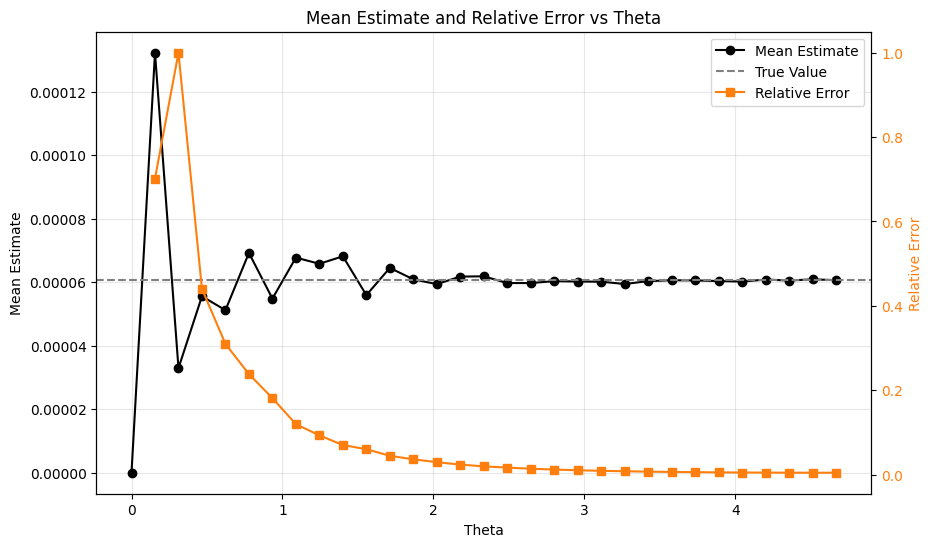

In [18]:
# Plot theta against mean estimate and relative error on separate y-axes
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot mean estimate on primary y-axis
ax1.plot(thetas, ests, label='Mean Estimate', marker='o', color="black")
ax1.set_xlabel('Theta')
ax1.set_ylabel('Mean Estimate')
ax1.tick_params(axis='y')
ax1.tick_params(axis='x')
ax1.grid(True, alpha=0.3)  # light muted grid

# Plot true value line
true_value = 6.066e-5
ax1.axhline(y=true_value, color="tab:grey", linestyle='--', label='True Value')

# Create secondary y-axis for relative error
ax2 = ax1.twinx()
ax2.plot(thetas, res, label='Relative Error', marker='s', color="tab:orange")

ax2.set_ylabel('Relative Error', color="tab:orange")
ax2.tick_params(axis='y', labelcolor="tab:orange")

# Combine legend
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()

ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='best')

plt.title('Mean Estimate and Relative Error vs Theta')

plt.show()


In [21]:
n = 1_000
b = 2.0

x = np.linspace(-3, 5, 1000)
fx = norm.pdf(x)

z = np.random.randn(n)
hz = z >= b

est = np.mean(hz)
se = sem(hz)
re = se / np.abs(est)

print(f"Plain MC Estimate: {est:.6f}, SE: {se:.6f}, RE: {re:.2%}")

Plain MC Estimate: 0.026000, SE: 0.005035, RE: 19.36%


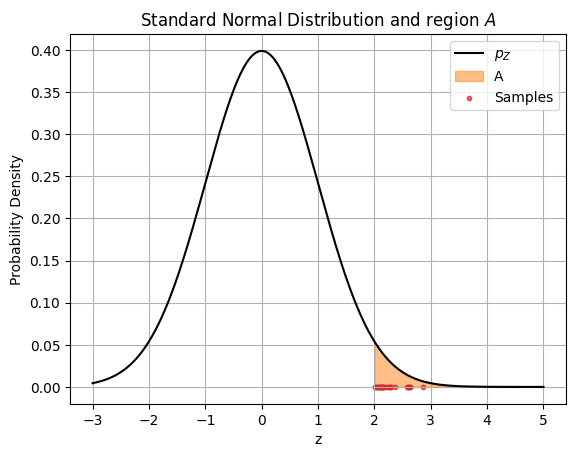

In [22]:
chfx = (x >= b) * norm.pdf(x) / est

plt.plot(x, fx, label='$p_Z$', color='black')
# plt.plot(x[x>= b], chfx[x>= b], label='$c h(x) f(x)$', color='black', linestyle='--')
plt.fill_between(x, fx, where=(x >= b), color='tab:orange', alpha=0.5, label='A')
plt.scatter(z[hz], np.zeros_like(z)[hz], color='tab:red', s=10, alpha=0.7, label='Samples')

plt.title('Standard Normal Distribution and region $A$')
plt.xlabel('z')
plt.ylabel('Probability Density')

# legend in top right corner
plt.legend(loc='upper right')
plt.grid()

plt.show()

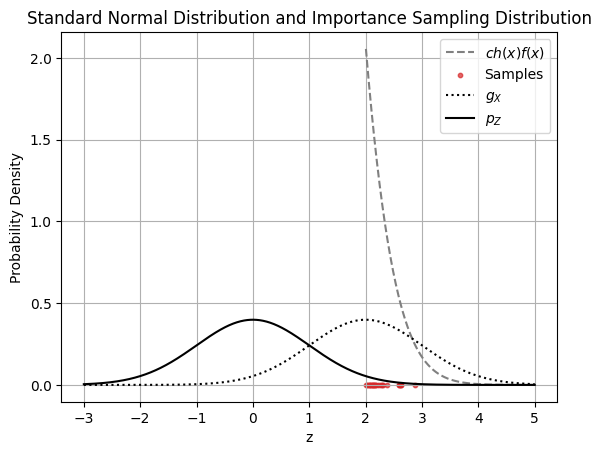

In [23]:
chfx = ( x>= b) * fx / est
plt.plot(x[x>= b], chfx[x>= b], label='$c h(x) f(x)$', color='grey', linestyle='--')
plt.scatter(z[hz], np.zeros_like(z)[hz], color='tab:red', s=10, alpha=0.7, label='Samples')

gx = norm.pdf(x, loc=2)
plt.plot(x, gx, label='$g_X$', color='black', linestyle='dotted')
plt.plot(x, fx, label='$p_Z$', color='black')

plt.title('Standard Normal Distribution and Importance Sampling Distribution')

plt.xlabel('z')
plt.ylabel('Probability Density')
plt.legend(loc='upper right')
plt.grid()
plt.show()

In [24]:
theta = 2.0
y = np.random.randn(n) + theta

hz = y >= b
tilt = np.exp(-theta * y + 0.5 * theta**2)

est = np.mean(hz * tilt)
se = sem(hz * tilt)
re = se / est * 100

print(f"IS MC Estimate: {est:.6f}, SE: {se:.6f}, RE: {re:.2f}%")

IS MC Estimate: 0.022649, SE: 0.001105, RE: 4.88%
